In [108]:
%reload_ext autoreload
%autoreload 2

import torch
import numpy as np
from torch import nn
from pathlib import Path
from torch.optim import Adam, AdamW, SGD
from matplotlib import pyplot as plt
from utils.plotting import plot_latent_trajectory, plot_neural_data
from data.dataset import NeuralDataset
from utils.plotting import plot_latent_trajectory_interactive
from utils.plotting import training_summary_plot

from models.layers import FactorizedEncoder, RecurrentFactorizedEncoder, AutoregressiveEncoder, PriorControlledEncoder
from models.layers import Transition, RecurrentDiscreteDecoder, GaussianLayer, ResidualBlock
from models.layers_experimental import AR1Transition
from models.vate_overshoot import VATE

device = 'cuda'


/home/nuzzi/Projects/NeuralEncoder_V2/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:829: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


NeuralDataset
  - Timepoints          : 5000
  - Device              : cuda
  - Dataset on device?  : True
  - Neural timeseries
	neural (continuous, shape=(5000, 32), multivariate=True)
  - Target labels timeseries
	behavior (discrete, shape=(5000, 1), multivariate=False)
  - Nuisance labels timeseries: None


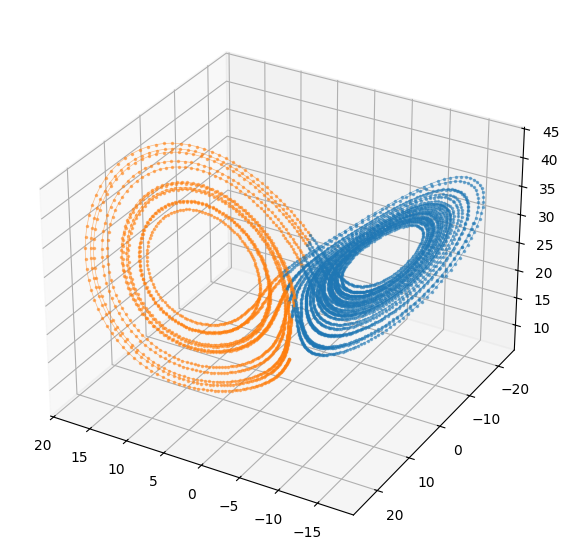

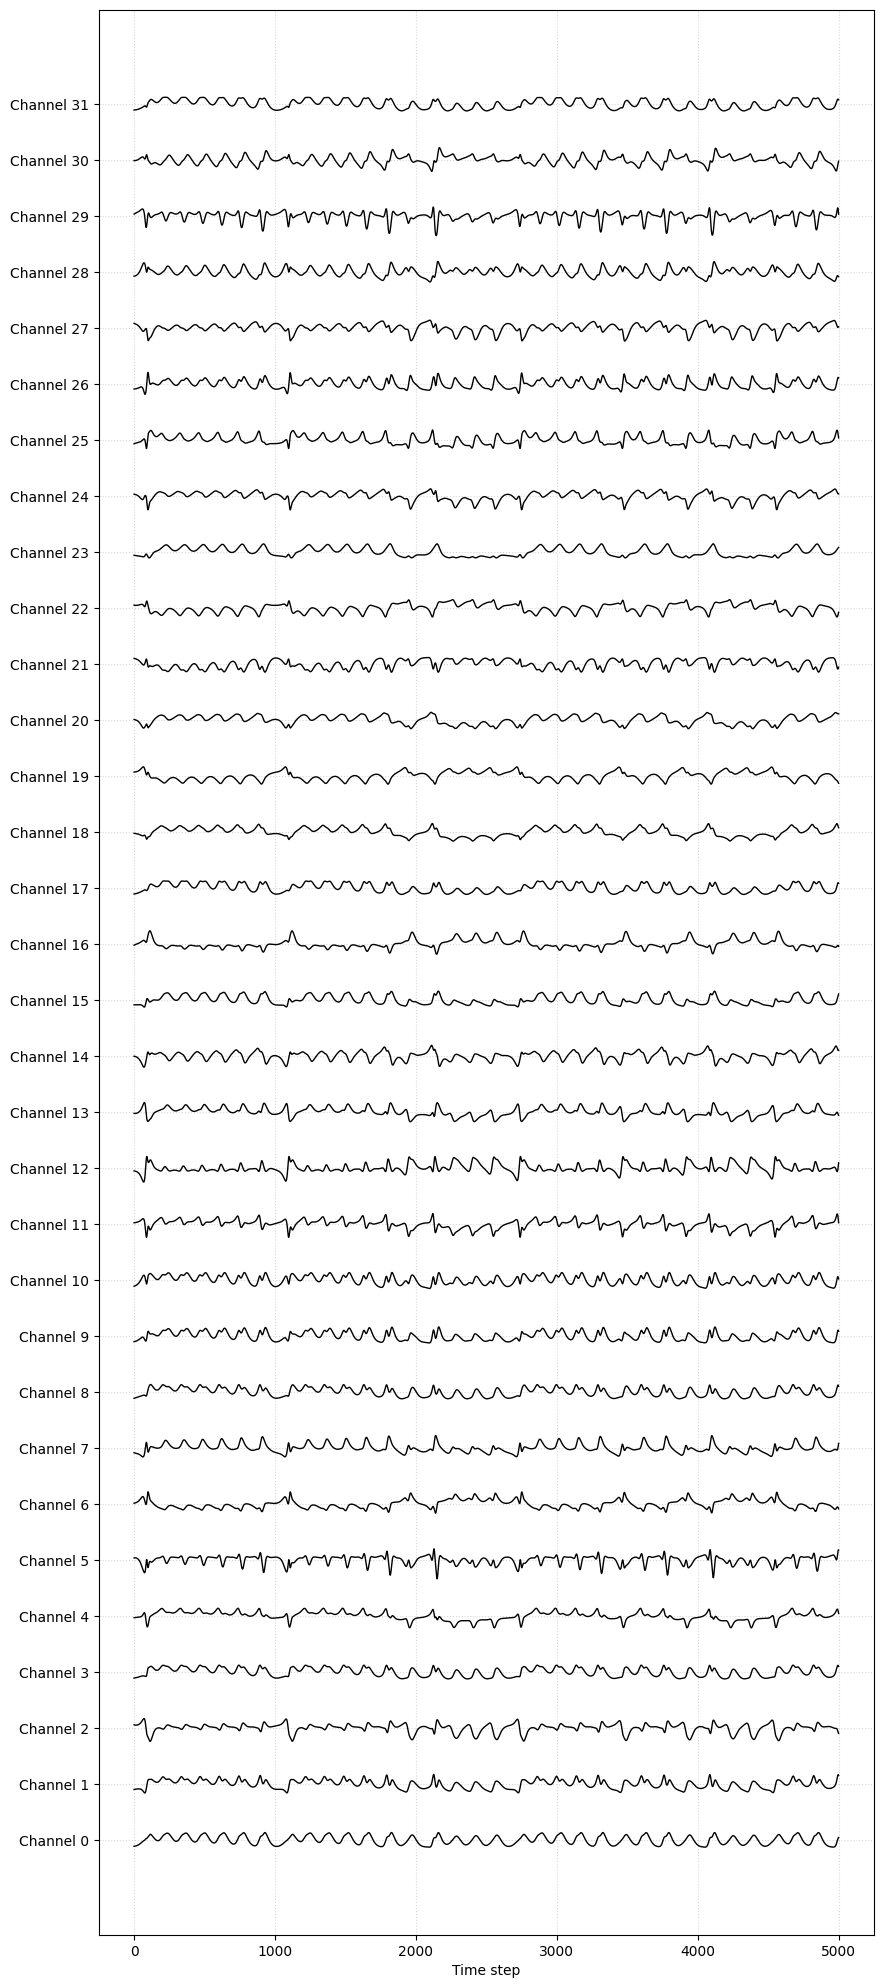

In [2]:
from data.datasets.lorenz import simulate_lorenz, get_lorenz_labels, create_neural_timeseries

x0 = np.array([0,1,10])
times = np.linspace(0,25,5000)
x_lorenz = simulate_lorenz(x0, times)
labels_lorenz = get_lorenz_labels(x_lorenz)
x_neural, mapping_matrix = create_neural_timeseries(x_lorenz, channels=32)
num_classes = 2
features_num = 32

plot_latent_trajectory(x_lorenz, labels_lorenz, markersize=3)
plot_neural_data(x_neural)

dataset = NeuralDataset(neural=x_neural,
                        target_labels={'behavior': labels_lorenz},
                        device=device
                        )

print(dataset)

NeuralDataset
  - Timepoints          : 2500
  - Device              : cuda
  - Dataset on device?  : True
  - Neural timeseries
	neural (continuous, shape=(2500, 32), multivariate=True)
  - Target labels timeseries
	behavior (discrete, shape=(2500, 1), multivariate=False)
  - Nuisance labels timeseries: None


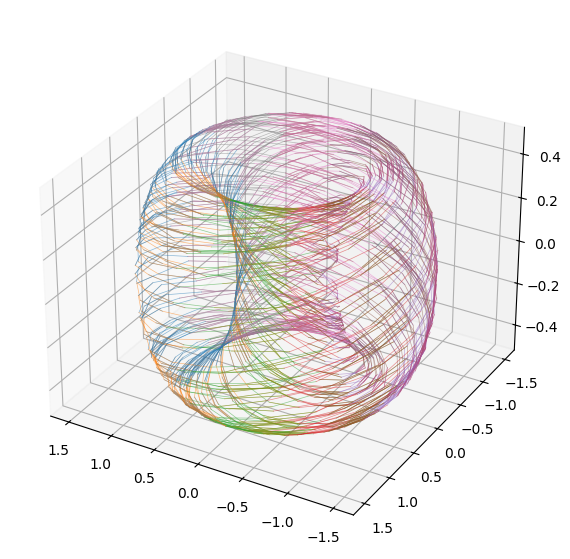

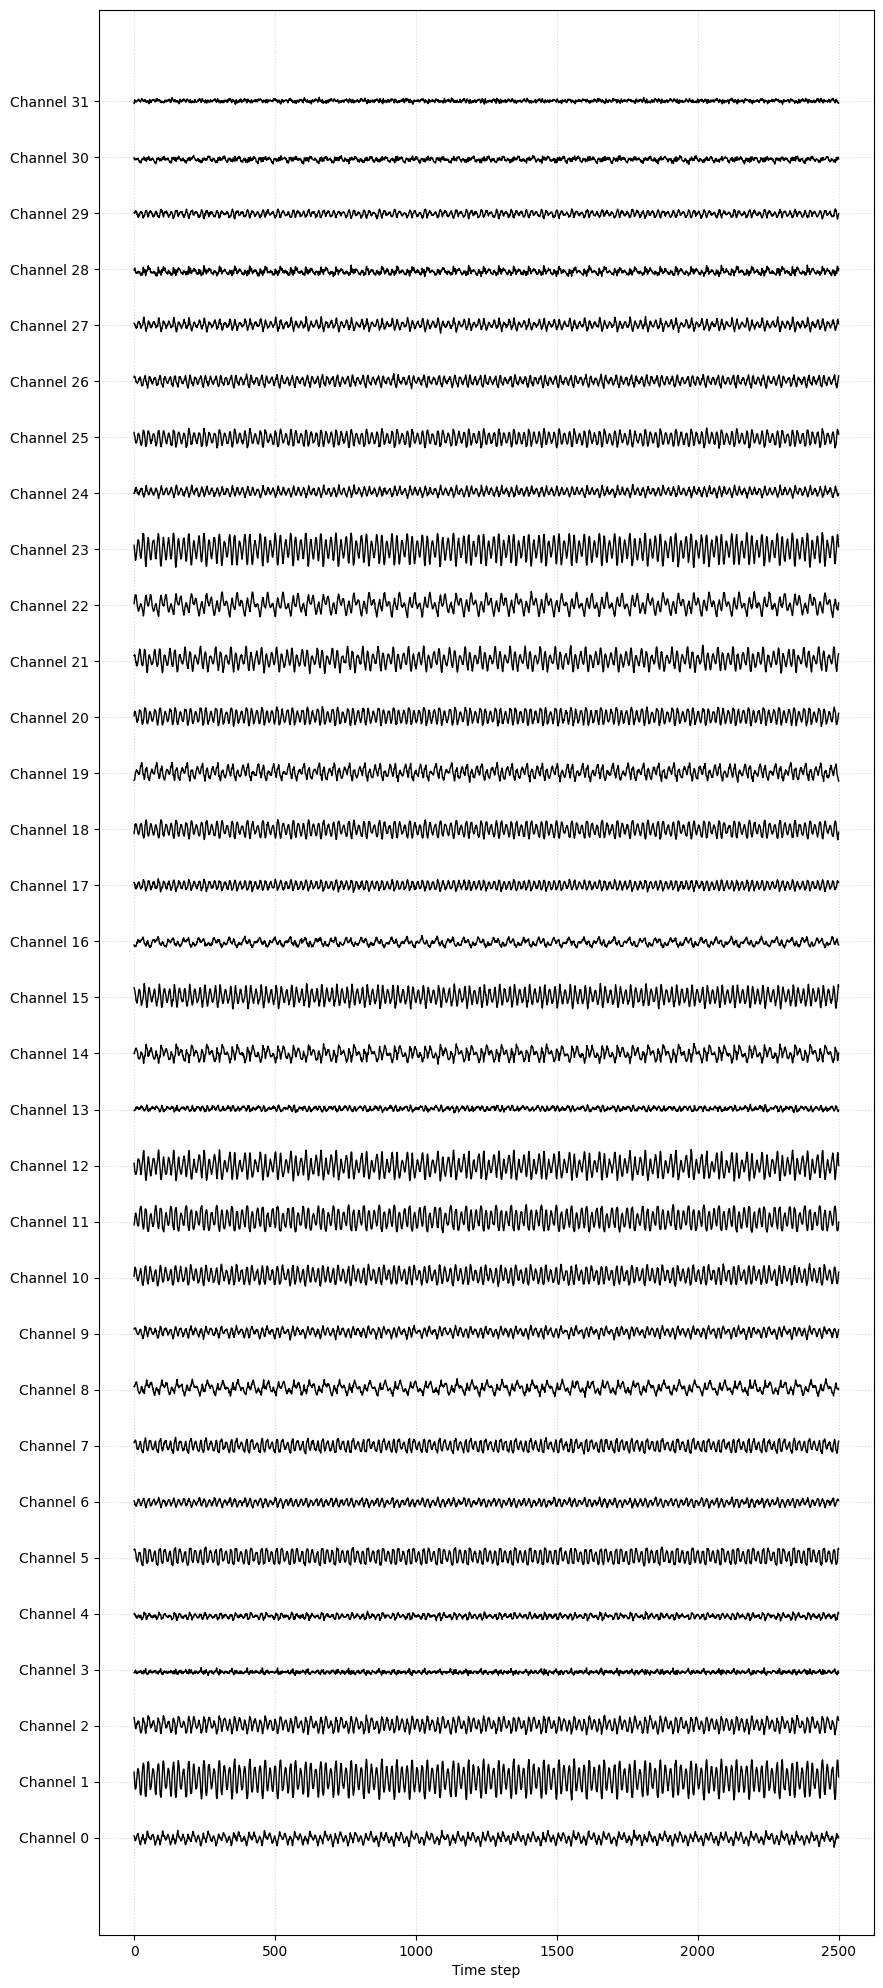

In [5]:
from data.datasets.torus import make_torus_timeseries

torus_data = make_torus_timeseries(T=25000, F=32, dt=0.1, R=1, r=0.5, subsample=10)
num_classes = 8
features_num = 32

plot_latent_trajectory(torus_data['latents'], torus_data['targets']['behavior'])
plot_neural_data(torus_data['neural'])

dataset = NeuralDataset(neural=torus_data['neural'],
                        target_labels={'behavior': torus_data['targets']['behavior']},
                        device=device
                        )

print(dataset)

NeuralDataset
  - Timepoints          : 3137
  - Device              : cuda
  - Dataset on device?  : True
  - Neural timeseries
	neural (continuous, shape=(3137, 109), multivariate=True)
  - Target labels timeseries
	behavior (discrete, shape=(3137, 1), multivariate=False)
  - Nuisance labels timeseries: None


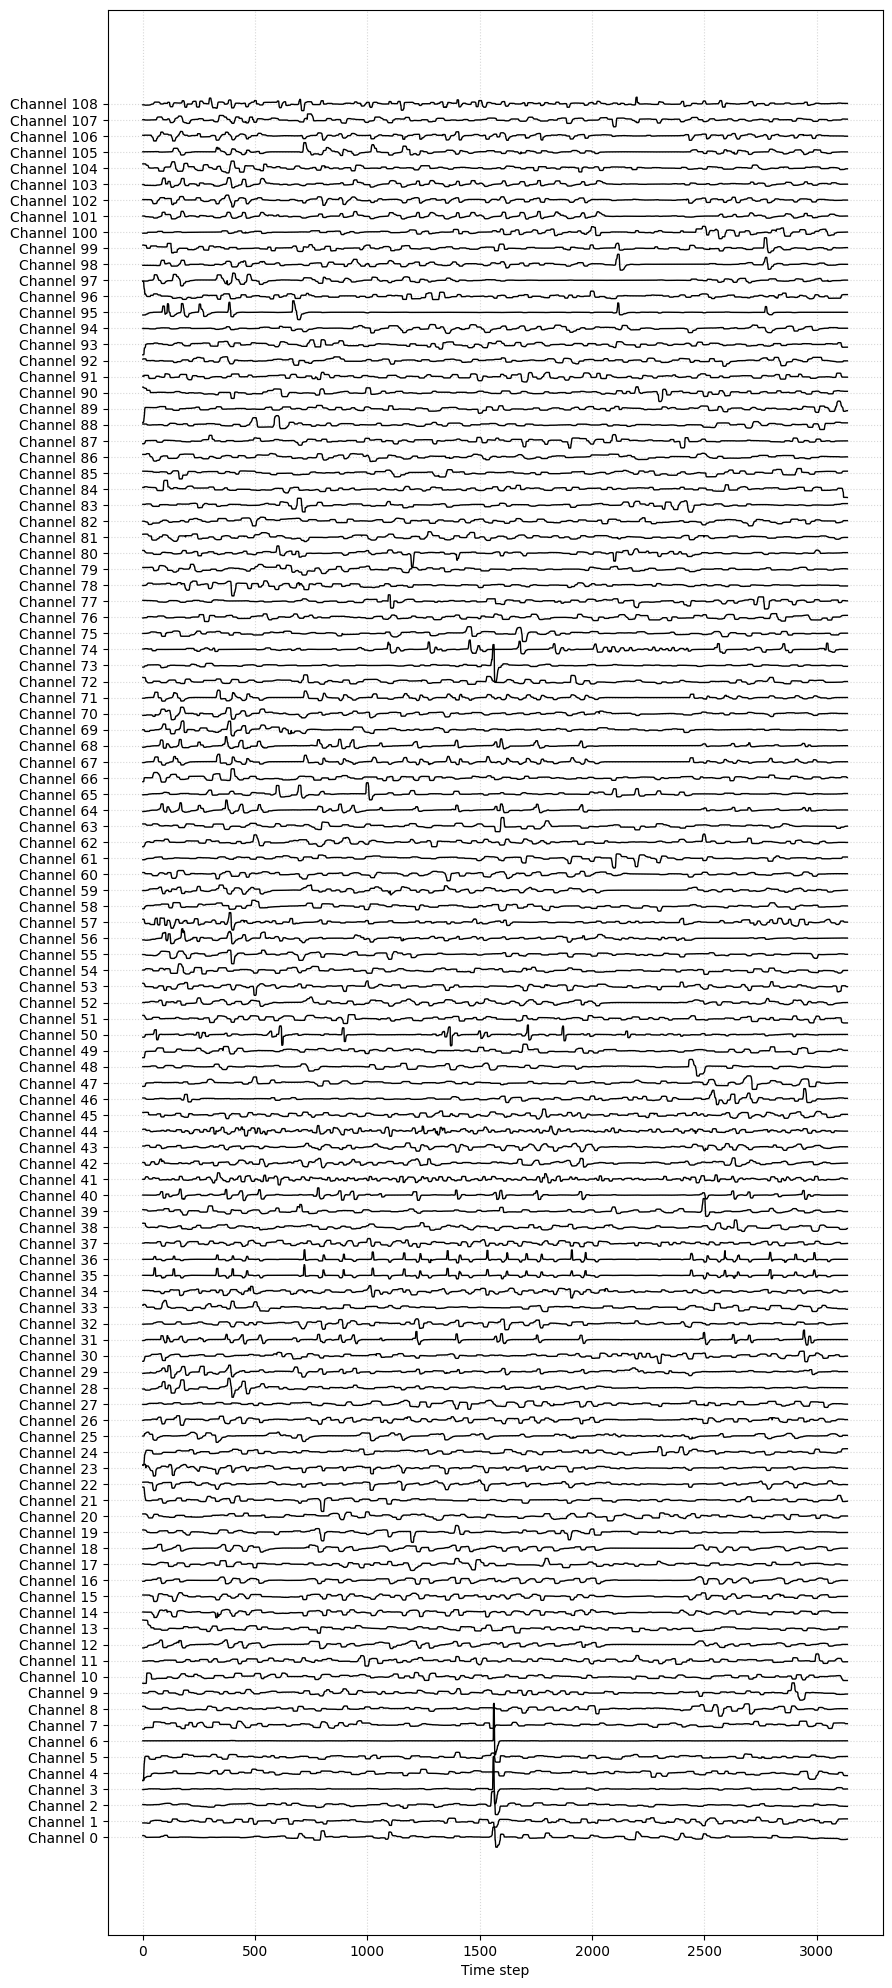

In [4]:
datapath = Path.cwd() / 'data' / 'datasets' /'CElegans' / 'worm_1'
neural_datapath = datapath / 'original_data.csv'
labels_datapath = datapath / 'behavioural_state.csv'

neural_data = np.genfromtxt(neural_datapath, delimiter=",", dtype=np.float32)
neural_data = torch.FloatTensor(neural_data)
neural_data = (neural_data - neural_data.mean(dim=(0), keepdim=True)) / neural_data.std(dim=(0), keepdim=True)

plot_neural_data(neural_data)

labels_behavior = np.genfromtxt(labels_datapath , delimiter=",", dtype=str)
behaviour_dict = {
    'fwd': 0,
    'slow': 1,
    'rev1': 2,
    'rev2': 3,
    'revsus': 4,
    'dt': 5,
    'vt': 6,
    'nostate': 7
} 

labels_behavior = [behaviour_dict[x] for x in labels_behavior]
labels_behavior = torch.LongTensor(labels_behavior).to(device)


dataset = NeuralDataset(neural=neural_data,
                        target_labels={'behavior': labels_behavior},
                        device=device
                        )

print(dataset)

features_num = 109
num_classes = 8


In [6]:
latent_dim = 3
hidden_dim = 16

# encoder = RecurrentFactorizedEncoder(
#     recurrent_module=nn.GRU(input_size=32, hidden_size=32, num_layers=1, batch_first=True, bidirectional=False),
#     body_module=nn.Sequential(
#         nn.LazyLinear(32), nn.GELU(),
#         nn.LazyLinear(64), nn.GELU(),
#         nn.LazyLinear(128), nn.GELU(),
#     ),
#     gaussian_module=GaussianLayer(output_dim=latent_dim, fixed_logvar=-9)
#     )

encoder = AutoregressiveEncoder(
    recurrent_module=nn.GRU(input_size=features_num, hidden_size=hidden_dim, num_layers=1, batch_first=True, bidirectional=False),
    body_module=nn.Sequential(
        nn.LazyLinear(hidden_dim),
        ResidualBlock(hidden_dim, expand_factor=4),
        ResidualBlock(hidden_dim, expand_factor=4),
        ResidualBlock(hidden_dim, expand_factor=4),
        nn.LayerNorm(hidden_dim)
    ),
    gaussian_module=GaussianLayer(output_dim=latent_dim, fixed_logvar=-10),
    residual_mode='simple'
    )

transition = Transition(
    body_module=nn.Sequential(
        nn.LazyLinear(hidden_dim),
        ResidualBlock(hidden_dim, expand_factor=4),
        ResidualBlock(hidden_dim, expand_factor=4),
        ResidualBlock(hidden_dim, expand_factor=4),
        nn.LayerNorm(hidden_dim)
    ),   
    gaussian_module=GaussianLayer(output_dim=latent_dim, fixed_logvar=-10),
    residual_mode='simple'
    )

decoder = RecurrentDiscreteDecoder(
    recurrent_module=nn.GRU(input_size=latent_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True, bidirectional=False),
    num_classes=num_classes
)

decoders = {'behavior': decoder}

model = VATE(encoder, transition, decoders).to(device)
model.summary(input_features=features_num)



Module         Parameters     
------------------------------
Encoder        9571           
Transition     6915           
Decoders       
-behavior      1042           
------------------------------
Total          17528          


In [7]:
model.load('Lorenz_Base_Regularized_Good.pt')

VATE(
  (encoder): AutoregressiveEncoder(
    (gaussian_module): GaussianLayer(
      (mean_layer): Linear(in_features=16, out_features=3, bias=True)
    )
    (body_module): Sequential(
      (0): Linear(in_features=19, out_features=16, bias=True)
      (1): ResidualBlock(
        (block): Sequential(
          (0): Linear(in_features=16, out_features=64, bias=True)
          (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (2): GELU(approximate='none')
          (3): Linear(in_features=64, out_features=16, bias=True)
        )
      )
      (2): ResidualBlock(
        (block): Sequential(
          (0): Linear(in_features=16, out_features=64, bias=True)
          (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (2): GELU(approximate='none')
          (3): Linear(in_features=64, out_features=16, bias=True)
        )
      )
      (3): ResidualBlock(
        (block): Sequential(
          (0): Linear(in_features=16, out_features=64, bias=True)
    

100%|██████████| 1/1 [00:00<00:00,  1.31it/s, total_loss=324, loss_prior=25.3, loss_transition=0.366, loss_targets_behavior=323, loss_repulsive=0.478, loss_multistep_consistency=10.6, loss_targets_prior_behavior=120]


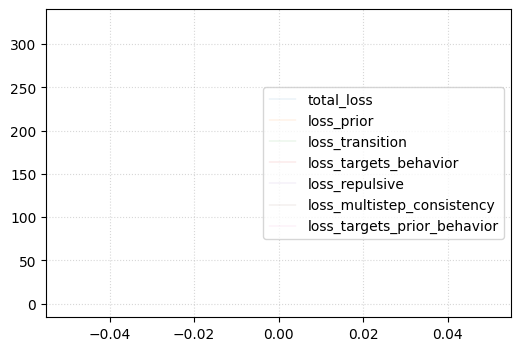

In [ ]:
# Training
optimizer = AdamW(model.parameters(), lr=1e-3)
losses_history = model.fit(dataset, iterations=5000, batch_size=256, window_len=50, overshoot_window=20,
                           variational_loss=False, optimizer=optimizer)

# Training plots
max_delta = 0
plt.figure(figsize=(6,4))
for loss_name in losses_history:
    plt.plot(losses_history[loss_name], label=loss_name, linewidth=0.2, alpha=0.5)
    max_delta = max(max_delta, np.max(losses_history[loss_name]) - np.min(losses_history[loss_name]))
plt.grid(True, linestyle=':', alpha=0.5)
if max_delta > 20:
    plt.yscale('log')
plt.legend()



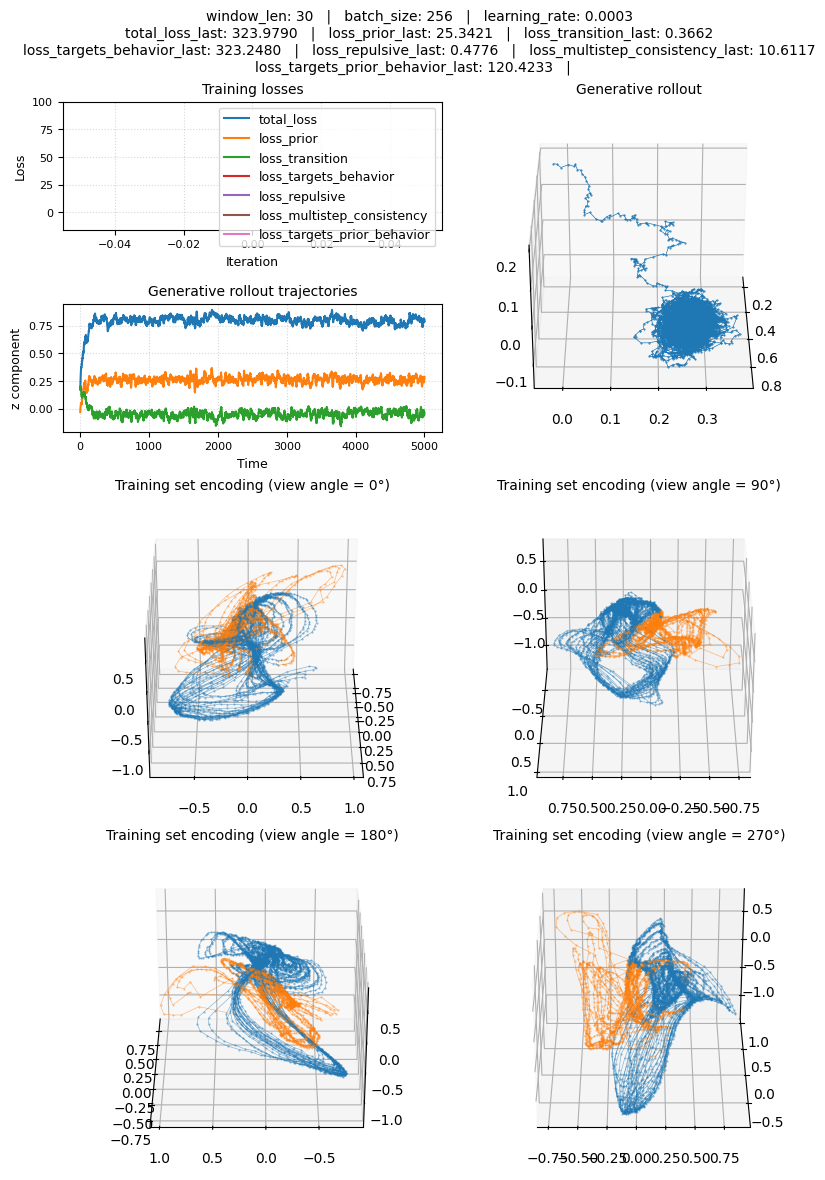

In [ ]:
# Model summary plot
training_summary_plot(model, dataset, losses_history, label_to_show='behavior',
                      title_args={'window_len': 30, 'batch_size': 256, 'learning_rate': 3e-4})


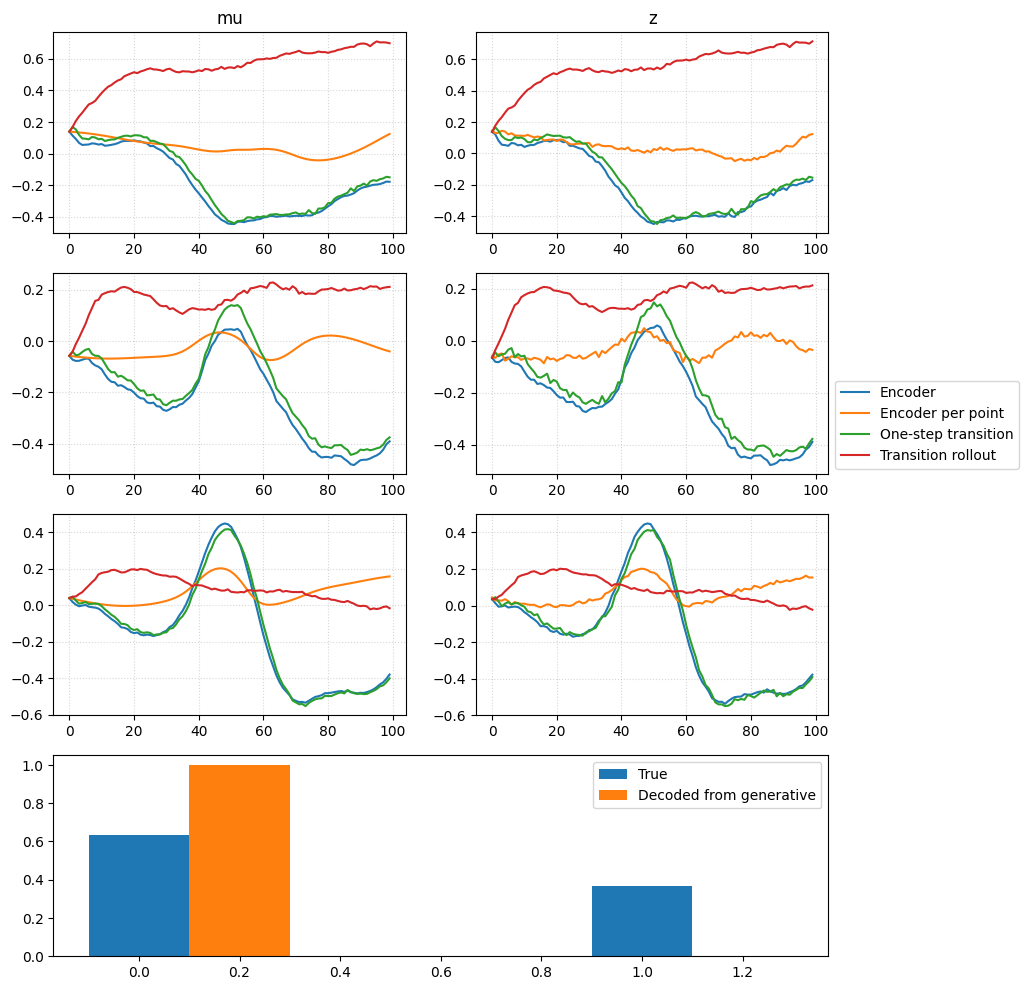

In [122]:
t_start = dataset.neural.data.shape[0] // 2
W = 100

# Encoded directly (autoregressive)
x_input = dataset.neural.data[t_start:t_start+W, :]

z_enc_full, mu_enc_full, _ = model.encoder(x_input)
z_enc_full = z_enc_full.squeeze()
mu_enc_full = mu_enc_full.squeeze()

# Encoded "per-point"
z_enc_point = []
mu_enc_point = []

for t in range(0, W):
    z_enc_p, mu_enc_p, _ = model.encoder(x_input[t:t+1,:])
    z_enc_point.append(z_enc_p.squeeze())
    mu_enc_point.append(mu_enc_p.squeeze())

z_enc_point = torch.stack(z_enc_point, dim=0)
mu_enc_point = torch.stack(mu_enc_point, dim=0)

# Encoded + transition (shifted)
z_trans_full, mu_trans_full, _ = model.transition(z_enc_full)

z_trans_full = torch.roll(z_trans_full, 1, dims=0)
mu_trans_full = torch.roll(mu_trans_full, 1, dims=0)
z_trans_full[0,:] = z_enc_full[0,:]
mu_trans_full[0,:] = mu_enc_full[0,:]

# Full transition from start
z_curr = z_enc_full[0,:].unsqueeze(0)
z_trans_rollout = [z_enc_full[0,:]]
mu_trans_rollout = [mu_enc_full[0,:]]

for t in range(W):
    z_next, mu_next, _ = model.transition(z_curr)
    z_trans_rollout.append(z_next.squeeze())
    mu_trans_rollout.append(mu_next.squeeze())
    z_curr = z_next

z_trans_rollout = torch.stack(z_trans_rollout, dim=0)
mu_trans_rollout = torch.stack(mu_trans_rollout, dim=0)
z_trans_rollout = z_trans_rollout[:-1, :]
mu_trans_rollout = mu_trans_rollout[:-1, :]

plt.figure(figsize=(10, 12))
for i in range(3):
    plt.subplot(4,2,i*2+1)
    plt.plot(mu_enc_full[:,i].detach().cpu(), label='Encoder')
    plt.plot(mu_enc_point[:,i].detach().cpu(), label='Encoder per point')
    plt.plot(mu_trans_full[:,i].detach().cpu(), label='One-step transition')
    plt.plot(mu_trans_rollout[:,i].detach().cpu(), label='Transition rollout')
    plt.grid(True, linestyle=':', alpha=0.5)
    if i == 0: plt.title('mu')

    plt.subplot(4,2,i*2+2)
    plt.plot(z_enc_full[:,i].detach().cpu(), label='Encoder')
    plt.plot(z_enc_point[:,i].detach().cpu(), label='Encoder per point')
    plt.plot(z_trans_full[:,i].detach().cpu(), label='One-step transition')
    plt.plot(z_trans_rollout[:,i].detach().cpu(), label='Transition rollout')
    plt.grid(True, linestyle=':', alpha=0.5)
    if i == 0: plt.title('z')

    if i == 1: plt.legend(bbox_to_anchor=(1,0.5))


# Label statistics
z_start, _, _ = model.encoder(dataset.neural.data[0,:])
z_start = z_start.squeeze()
z_curr = z_start.unsqueeze(0)
z_trans_rollout = [z_start]

for t in range(dataset.neural.data.shape[0]):
    z_next, mu_next, _ = model.transition(z_curr)
    z_trans_rollout.append(z_next.squeeze())
    z_curr = z_next

z_trans_rollout = torch.stack(z_trans_rollout, dim=0)
z_trans_rollout = z_trans_rollout[:-1, :]

y_decoded = model.target_decoders['behavior'](z_trans_rollout)

y_decoded_class = torch.argmax(y_decoded, dim=-1).detach().cpu()
y_real_class = dataset.target_labels['behavior'].data.detach().cpu()
classes = np.unique(y_real_class)
classes = np.concatenate((classes, [classes.max()+1])) - 0.5

plt.subplot(4,1,4)
plt.hist(y_real_class, classes, density=True, rwidth=0.2, label='True')
plt.hist(y_decoded_class+0.2, classes+0.2, density=True, rwidth=0.2, label='Decoded from generative')
plt.legend()

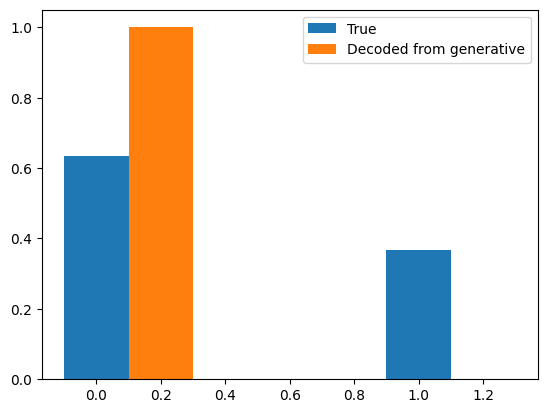

In [106]:
# Label statistics
z_start, _, _ = model.encoder(dataset.neural.data[0,:])
z_start = z_start.squeeze()
z_curr = z_start.unsqueeze(0)
z_trans_rollout = [z_start]

for t in range(dataset.neural.data.shape[0]):
    z_next, mu_next, _ = model.transition(z_curr)
    z_trans_rollout.append(z_next.squeeze())
    z_curr = z_next

z_trans_rollout = torch.stack(z_trans_rollout, dim=0)
z_trans_rollout = z_trans_rollout[:-1, :]

y_decoded = model.target_decoders['behavior'](z_trans_rollout)

y_decoded_class = torch.argmax(y_decoded, dim=-1).detach().cpu()
y_real_class = dataset.target_labels['behavior'].data.detach().cpu()
classes = np.unique(y_real_class)
classes = np.concatenate((classes, [classes.max()+1])) - 0.5

plt.figure()
plt.hist(y_real_class, classes, density=True, rwidth=0.2, label='True')
plt.hist(y_decoded_class+0.2, classes+0.2, density=True, rwidth=0.2, label='Decoded from generative')
plt.legend()

In [107]:
z_latent, mu_latent, _ = model.encoder(dataset.neural.data.unsqueeze(0).unsqueeze(0))
z_latent = z_latent.squeeze()
mu_latent = mu_latent.squeeze()
plot_latent_trajectory_interactive(mu_latent, dataset.target_labels['behavior'].data, markersize=1)



In [12]:
x0 = dataset.neural.data[0,:]
generation_result = model.generate(x0=x0, num_steps=5000)
z_rollout, target_labels_rollout = generation_result['z_sequence'], generation_result['target_preds']
target_label_rollout_class = torch.argmax(target_labels_rollout['behavior'], axis=-1)

plot_latent_trajectory_interactive(z_rollout, target_label_rollout_class, markersize=1)




torch.Size([3000, 2])


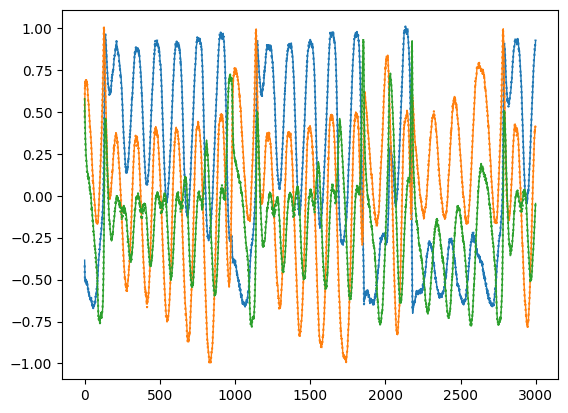

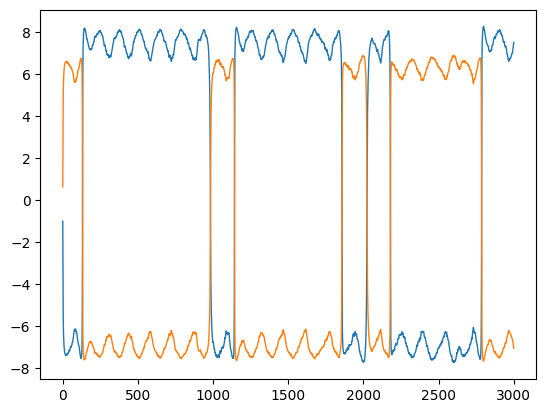

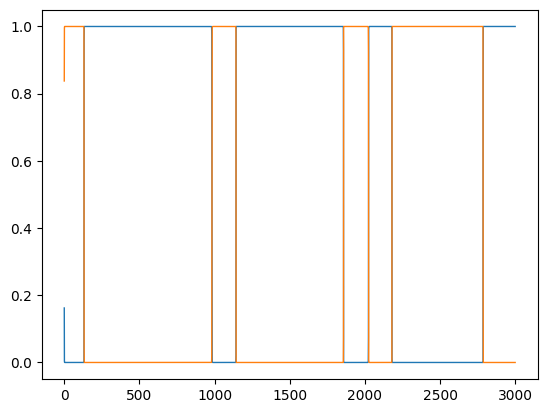

In [56]:
x = torch.FloatTensor(x_neural[0:3000,:]).to(device)
z_enc = model.encoder(x.unsqueeze(0).unsqueeze(0))[0].squeeze()
z_trans = model.transition(z_enc.unsqueeze(0).unsqueeze(0))[0].squeeze()
y_prob = model.target_decoders['behavior'](z_enc.unsqueeze(0).unsqueeze(0)).squeeze()

print(y_prob.shape)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure()

for i in range(3):
    plt.plot(z_enc[:,i].detach().cpu().numpy(), color=colors[i], linewidth=1)
    plt.plot(z_trans[:,i].detach().cpu().numpy(), linestyle=':', color=colors[i])

plt.figure()
plt.plot(y_prob.detach().cpu().numpy(), linewidth=1)

plt.figure()
plt.plot(torch.softmax(y_prob, dim=-1).detach().cpu().numpy(), linewidth=1)


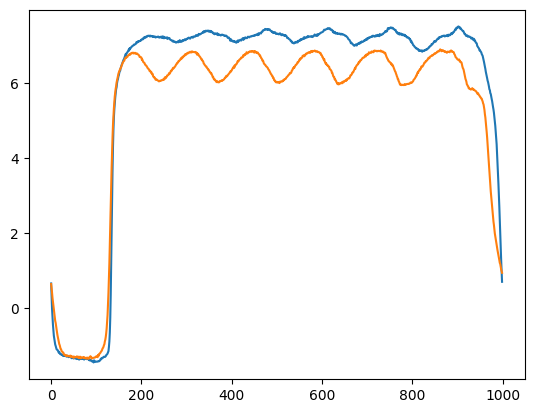

In [ ]:
# Check the difference between encoding at t=0 for all points and encoding in the autoregressive way
x = torch.FloatTensor(x_neural[0:1000,:]).to(device)
z_enc = model.encoder(x.unsqueeze(0).unsqueeze(0))[0].squeeze()

z_enc_single = []
for t in range(0, 1000):
    x = torch.FloatTensor(x_neural[t:t+1,:]).to(device)
    z_enc_single.append(model.encoder(x.unsqueeze(0).unsqueeze(0))[0].squeeze())

z_enc_single = torch.stack(z_enc_single, dim=0)

plt.figure()
plt.plot(z_enc[:, 0].detach().cpu())
# plt.figure()
plt.plot(z_enc_single[:, 0].detach().cpu())


In [57]:
model.save('Lorenz_Base_Regularized_Good.pt')